In [19]:
'''
This is to build a model which aligns the image of the camera with steering 
input to centre the car in the lane

It requires images with relevant steering inputs already generated
'''
import keras
import os
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD
import numpy as np

#constants to resize image to
HEIGHT = 360
WIDTH = 640

#get a lsit of files
mypath = 'C:/SelfDrive/_out'
only_images = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".png")]
only_steering = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".str")]
# get a list when both are available: image and steering
complete_names = set(only_images).intersection(only_steering)

# read training data 

X = [] #images
Y = [] #expected steering for this image
for example in complete_names:
    img_path = mypath+'/'+example+'.png'
    str_path = mypath+'/'+example+'.str'
     
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    X.append(image[:, :, None] / 255) # adding another dimension and normalising pixels to 0-1
    # max value of Y during writing of this was 0.79 so no need to convert it to 0-1
    
    f = open(str_path,'r')
    y = f.readline()
    Y.append(float(y))

X = np.array(X)
Y = np.array(Y)

In [21]:
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(HEIGHT, WIDTH,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.3)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 360, 640, 8)       80        
                                                                 
 activation_6 (Activation)   (None, 360, 640, 8)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 180, 320, 8)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 460800)            0         
                                                                 
 dense_4 (Dense)             (None, 32)                14745632  
                                                                 
 activation_7 (Activation)   (None, 32)                0         
                                                      

In [ ]:
# need to get to 0.002 and below to be within 5% ish

In [1]:
'''
next iteration:

deal with activation at the end to allow negative values - by re-scaling Y labels to center around 0.5

focus on certain screen area

'''
import keras
import os
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD
import numpy as np

#constants to resize image to
HEIGHT = 360
WIDTH = 640

HEIGHT_REQUIRED_PORTION = 0.4 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.5

height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

#get a lsit of files
mypath = 'C:/SelfDrive/_out'
only_images = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".png")]
only_steering = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".str")]
# get a list when both are available: image and steering
complete_names = set(only_images).intersection(only_steering)

# read training data 

X = [] #images
Y = [] #expected steering for this image
for example in complete_names:
    img_path = mypath+'/'+example+'.png'
    str_path = mypath+'/'+example+'.str'
     
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    image = image[height_from:,width_from:width_to]
    
    X.append(image[:, :, None] / 255) # adding another dimension and normalising pixels to 0-1
    # max value of Y during writing of this was 0.79 so no need to convert it to 0-1
    
    f = open(str_path,'r')
    y = f.readline()
    Y.append(float(y))

X = np.array(X)
Y = np.array(Y)
Y = Y/2 + 0.5 # transforming Y from [-1:+1] to [0:1]

In [3]:
#initial model giving good results - needs to be checked against a real driving scenario
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit(X, Y, batch_size=32, epochs=5, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 144, 320, 64)      640       
                                                                 
 activation_5 (Activation)   (None, 144, 320, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 72, 160, 64)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 160, 64)       36928     
                                                                 
 activation_6 (Activation)   (None, 72, 160, 64)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 80, 64)       0         
 2D)                                                  

In [2]:
#adding an extra layer - no difference - not saved
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 320, 64)      640       
                                                                 
 activation (Activation)     (None, 144, 320, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 72, 160, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 160, 64)       36928     
                                                                 
 activation_1 (Activation)   (None, 72, 160, 64)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 80, 64)       0         
 2D)                                                    

In [8]:
cv2.imshow("image", image)
cv2.waitKey(0)

-1

In [4]:
#saving model
model.save("lane_model_360x640_04_05", overwrite=False,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: lane_model_360x640_04_05\assets


INFO:tensorflow:Assets written to: lane_model_360x640_04_05\assets


In [1]:
# checking predictions randomly
# step 1 - load images and model

import os

from tensorflow import keras
from tensorflow.keras.models import load_model
import cv2

import numpy as np

#constants to resize image to
HEIGHT = 360
WIDTH = 640

HEIGHT_REQUIRED_PORTION = 0.4 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.5

height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

#get a lsit of files
mypath = 'C:/SelfDrive/_out'
only_images = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".png")]
only_steering = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".str")]
# get a list when both are available: image and steering
complete_names = set(only_images).intersection(only_steering)

# read training data 

X = [] #images
Y = [] #expected steering for this image
for example in complete_names:
    img_path = mypath+'/'+example+'.png'
    str_path = mypath+'/'+example+'.str'
     
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    image = image[height_from:,width_from:width_to]
    
    X.append(image[:, :, None] / 255) # adding another dimension and normalising pixels to 0-1
    # max value of Y during writing of this was 0.79 so no need to convert it to 0-1
    
    f = open(str_path,'r')
    y = f.readline()
    Y.append(float(y))

X = np.array(X)
Y = np.array(Y)
Y = Y/2 + 0.5 # transforming Y from [-1:+1] to [0:1]

model = load_model('C:/SelfDrive/lane_model_360x640_04_05',compile=False)
model.compile()

In [10]:
# demo below of how to check what the model predicts for the most extreme case

#selecting max actual steering angle from Y/labels
Y.argmax()

9692

In [11]:
#confirm actual steering value
Y[9692]

0.89985

In [12]:
#show the corresponding X image
cv2.imshow("test",X[9692])
cv2.waitKey(0)

-1

In [13]:
#predict the value using the model - it shows 0.495 which is straight steering - WRONG !!!
model.predict([X[9692].reshape(-1, X[9692].shape[0], X[9692].shape[1], 1) ])

1/1 [==============================] - 0s 15ms/step


array([[0.4951062]], dtype=float32)

In [15]:
# predict all from X
_y = model.predict(X)

395/395 [==============================] - 6s 14ms/step


In [16]:
# check man
max(_y)

array([0.4951062], dtype=float32)

In [17]:
# check min
min(_y)

array([0.4951062], dtype=float32)

In [18]:
# Conclusion - the model always predict staright steering

In [21]:
from matplotlib import pyplot as plt

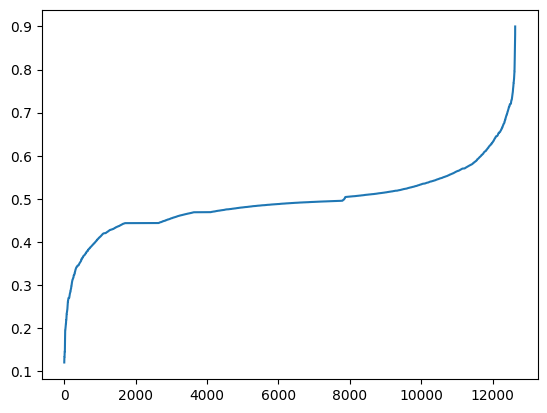

In [27]:
plt.plot(Y)
plt.show()

In [28]:
# conclusion - more examples needed with steeper steering - the model essentially learns on near straight wheel

In [1]:
'''
next iteration:

deal with balancing - remove some examples from densely populated range of steering close to centre

'''
from tensorflow import keras
from tensorflow.keras.models import load_model
import os
import cv2

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, concatenate, Embedding, Reshape, Flatten, Activation
from tensorflow.keras.optimizers import SGD
import numpy as np

#constants to resize image to
HEIGHT = 180
WIDTH = 320

HEIGHT_REQUIRED_PORTION = 0.4 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.5

KEEP_ONLY = 5 #keep every X-th row from dense range

height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

#get a lsit of files
mypath = 'C:/SelfDrive/_out'
only_images = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".png")]
only_steering = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".str")]
# get a list when both are available: image and steering
complete_names = set(only_images).intersection(only_steering)

# read training data 

X = [] #images
Y = [] #expected steering for this image
for example in complete_names:
    img_path = mypath+'/'+example+'.png'
    str_path = mypath+'/'+example+'.str'
     
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    image = image[height_from:,width_from:width_to]
    
    X.append(image[:, :, None] / 255) # adding another dimension and normalising pixels to 0-1
    # max value of Y during writing of this was 0.79 so no need to convert it to 0-1
    
    f = open(str_path,'r')
    y = f.readline()
    Y.append(float(y))

X = np.array(X)
Y = np.array(Y)
Y = Y/2 + 0.5 # transforming Y from [-1:+1] to [0:1]

#shuffle in unison
p = np.random.permutation(len(Y))
X = X[p]
Y = Y[p]

# thin the data in dense area around 0.5
filter_arr = []
counter = 0

for element in Y:
    if element > 0.38 and element <0.62:
        if counter % KEEP_ONLY == 0:
            filter_arr.append(True)
        else:
            filter_arr.append(False)
    else:
        filter_arr.append(True)
    counter +=1

# remove some over-reepresented examples in 0.4-0.6 range - around straight
X = X[filter_arr]
Y = Y[filter_arr]

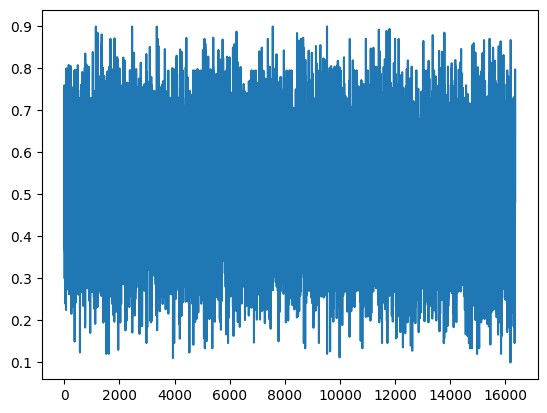

In [2]:
from matplotlib import pyplot as plt
plt.plot(Y)
plt.show()


In [9]:
#initial model giving good results - needs to be checked against a real driving scenario
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  
model.add(Dense(26))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('relu'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit(X, Y, batch_size=8, epochs=2, validation_split=0.25)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 72, 160, 32)       320       
                                                                 
 activation_28 (Activation)  (None, 72, 160, 32)       0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 36, 80, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 36, 80, 32)        9248      
                                                                 
 activation_29 (Activation)  (None, 36, 80, 32)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 18, 40, 32)       0         
 g2D)                                                 

In [18]:
#show the corresponding X image
cv2.imshow("test",X[0])
cv2.waitKey(0)

-1

In [13]:
Y.argmax()

1146

In [17]:
Y[0]

0.30185

In [2]:
'''
pick max steering file example

'''
import os
import cv2

import numpy as np

#constants to resize image to
#get a lsit of files
mypath = 'C:/SelfDrive/_out'
only_steering = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".str")]
max_value = 0
min_value = 1
for example in only_steering:
    str_path = mypath+'/'+example+'.str'
    f = open(str_path,'r')
    y = f.readline()
    if float(y)> max_value:
        max_value = float(y)
        max_counter = str_path
    if float(y) < min_value:
        min_value = float(y)
        min_counter = str_path
    

print('min value file: ',min_counter)
print('max value file: ',max_counter)


min value file:  C:/SelfDrive/_out/025106.str
max value file:  C:/SelfDrive/_out/003768.str


NameError: name 'Y' is not defined